In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Check for GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device Name:", tf.test.gpu_device_name())


Num GPUs Available: 1
GPU Device Name: /device:GPU:0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import kagglehub

In [ ]:


# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
import shutil
import os
# Define your Google Drive path (where you want the dataset to be stored)
drive_path = "/content/drive/MyDrive/DL_Project/dataset_new"

# Ensure the directory exists
os.makedirs(drive_path, exist_ok=True)

# Move the dataset from KaggleHub cache to Google Drive
shutil.move('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1', drive_path)

print(f"Dataset moved to: {drive_path}")


In [ ]:
# Set image dimensions for resizing
IMG_SIZE = 224  # Example size, adjust as needed
TRAIN_DIR = '/content/drive/MyDrive/DL_Project/dataset_new/1/Training'  # Path to your training directory
TEST_DIR = '/content/drive/MyDrive/DL_Project/dataset_new/1/Testing'  # Path to your testing directory

# Directory names for labels
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


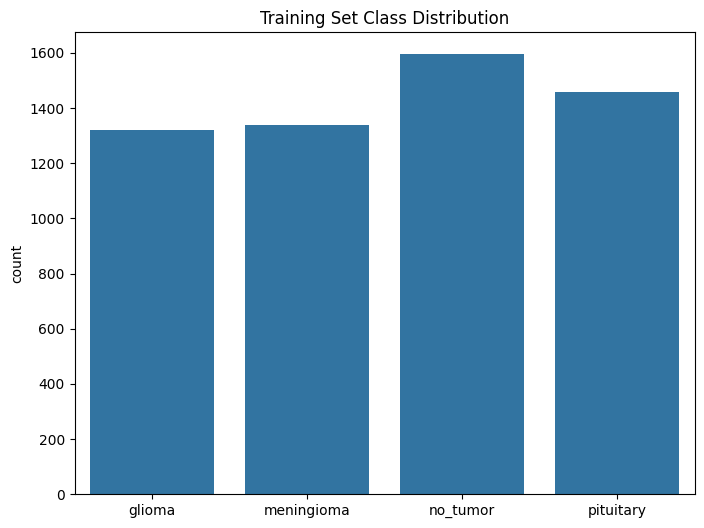

In [ ]:
# Data Augmentation (optional)
datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# Image data generator for training and testing datasets
train_gen = datagen.flow_from_directory(
    TRAIN_DIR,  # Path to training data directory
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images
    batch_size=32,  # Number of images to return in each batch
    class_mode='categorical'  # For multi-class classification
)

test_gen = datagen.flow_from_directory(
    TEST_DIR,  # Path to testing data directory
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images
    batch_size=32,  # Number of images to return in each batch
    class_mode='categorical'  # For multi-class classification
)

# Check the class distribution in the training set
train_labels = train_gen.classes
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title('Training Set Class Distribution')
plt.show()


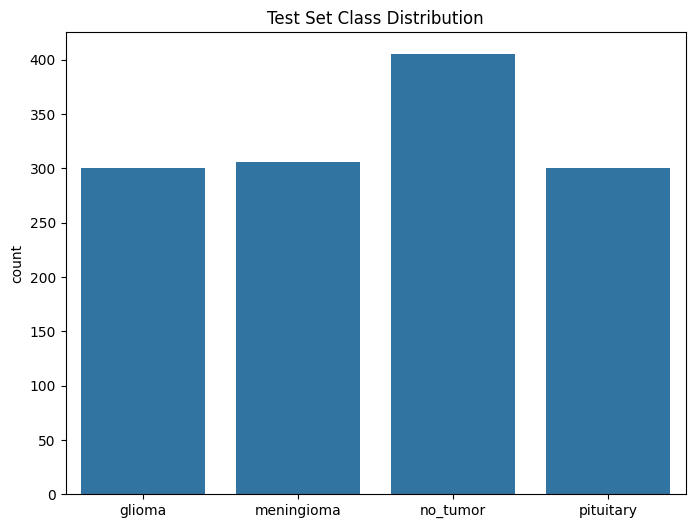

In [ ]:
# Check the class distribution in the test set
test_labels = test_gen.classes
plt.figure(figsize=(8, 6))
sns.countplot(x=test_labels)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title('Test Set Class Distribution')
plt.show()


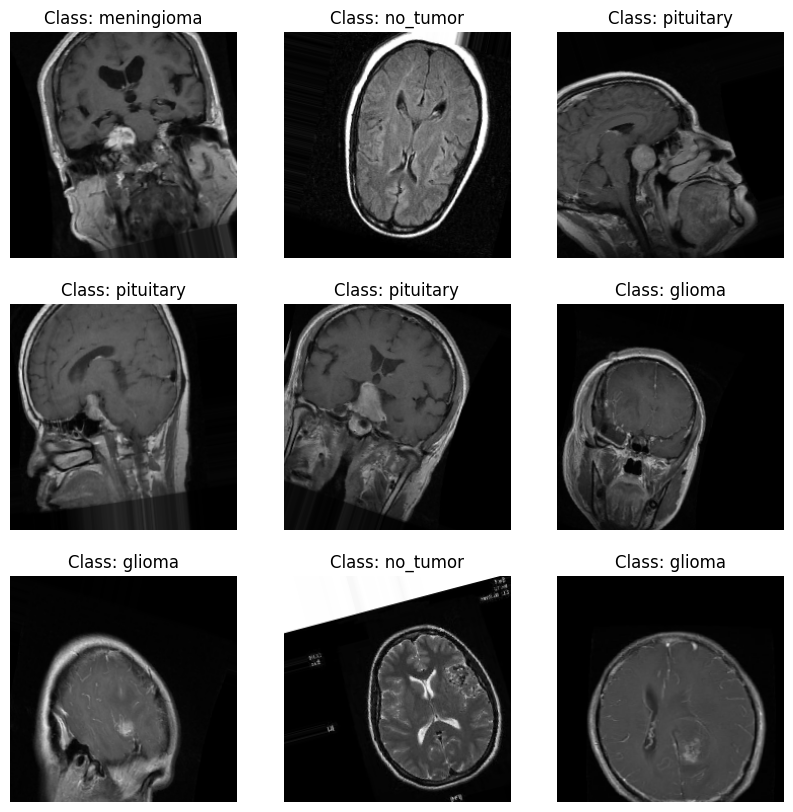

In [ ]:
# Load a few sample images from the training set
sample_imgs, sample_labels = next(train_gen)  # Get a batch of images and labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_imgs[i])  # The image is already normalized
    plt.title(f'Class: {class_names[np.argmax(sample_labels[i])]}')
    plt.axis('off')
plt.show()


In [ ]:
# Compute class weights to address class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.arange(len(class_names)),
    y=train_labels
)
class_weights_dict = dict(zip(np.arange(len(class_names)), class_weights))
print("Class weights:", class_weights_dict)


Class weights: {np.int64(0): np.float64(1.080999242997729), np.int64(1): np.float64(1.0664675130694548), np.int64(2): np.float64(0.8952978056426333), np.int64(3): np.float64(0.9800960878517502)}


In [ ]:
# Example: Create and compile a CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes for classification
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, epochs=10, validation_data=test_gen, class_weight=class_weights_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1903s 11s/step - accuracy: 0.4637 - loss: 1.3633 - val_accuracy: 0.5912 - val_loss: 1.0003
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 624ms/step - accuracy: 0.6390 - loss: 0.8974 - val_accuracy: 0.6461 - val_loss: 0.8779
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 621ms/step - accuracy: 0.6808 - loss: 0.8129 - val_accuracy: 0.6812 - val_loss: 0.7953
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 608ms/step - accuracy: 0.7144 - loss: 0.7539 - val_accuracy: 0.6903 - val_loss: 0.7844
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 617ms/step - accuracy: 0.7083 - loss: 0.7552 - val_accuracy: 0.6552 - val_loss: 0.8028
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 613ms/step - accuracy: 0.7283 - loss: 0.6993 - val_accuracy: 0.7223 - val_loss: 0.6904
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 618ms/step - accuracy: 0.7437 - loss: 0.6908 - val_accuracy: 0.7094 - val_loss: 0.6808
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 613ms/step - accuracy: 0.7463 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 472ms/step - accuracy: 0.7245 - loss: 0.6301
Test Accuracy: 0.7094


In [ ]:
model.save('/content/drive/MyDrive/DL_Project/models/brain_tumor_cnn.h5')


In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('brain_tumor_cnn.h5')


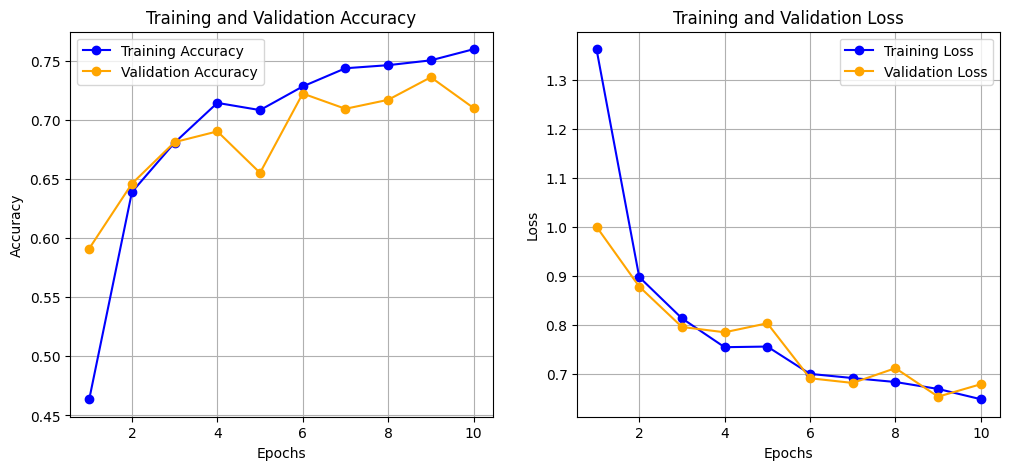

In [ ]:
import matplotlib.pyplot as plt

# Training history values (extracted from logs)
epochs = list(range(1, 11))  # 10 epochs

train_accuracy = [0.4637, 0.6390, 0.6808, 0.7144, 0.7083, 0.7283, 0.7437, 0.7463, 0.7504, 0.7598]
val_accuracy = [0.5912, 0.6461, 0.6812, 0.6903, 0.6552, 0.7223, 0.7094, 0.7170, 0.7361, 0.7101]

train_loss = [1.3633, 0.8974, 0.8129, 0.7539, 0.7552, 0.6993, 0.6908, 0.6827, 0.6685, 0.6475]
val_loss = [1.0003, 0.8779, 0.7953, 0.7844, 0.8028, 0.6904, 0.6808, 0.7110, 0.6527, 0.6782]

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, marker='o', label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color='blue')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Load DenseNet121 with pre-trained ImageNet weights, excluding the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for transfer learning

# Add custom classifier layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4-class classification

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(train_gen, validation_data=test_gen, epochs=10, callbacks=[early_stopping])




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 842ms/step - accuracy: 0.3348 - loss: 1.8016 - val_accuracy: 0.7246 - val_loss: 0.7548
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 642ms/step - accuracy: 0.5914 - loss: 0.9916 - val_accuracy: 0.7788 - val_loss: 0.6395
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 628ms/step - accuracy: 0.6743 - loss: 0.8303 - val_accuracy: 0.7857 - val_loss: 0.6127
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 639ms/step - accuracy: 0.6891 - loss: 0.7561 - val_accuracy: 0.7986 - val_loss: 0.5656
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 621ms/step - accuracy: 0.7398 - loss: 0.6757 - val_accuracy: 0.7933 - val_loss: 0.5539
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 635ms/step - accuracy: 0.7282 - loss: 0.6633 - val_accuracy: 0.7994 - val_loss: 0.5467
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 113s 632ms/step - accuracy: 0.7532 - loss: 0.6400 - val_accuracy: 0.8124 - val_loss: 0.5228
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 637ms/step - accuracy: 0.7600 -

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 527ms/step - accuracy: 0.7954 - loss: 0.5496
Test Accuracy: 0.8169


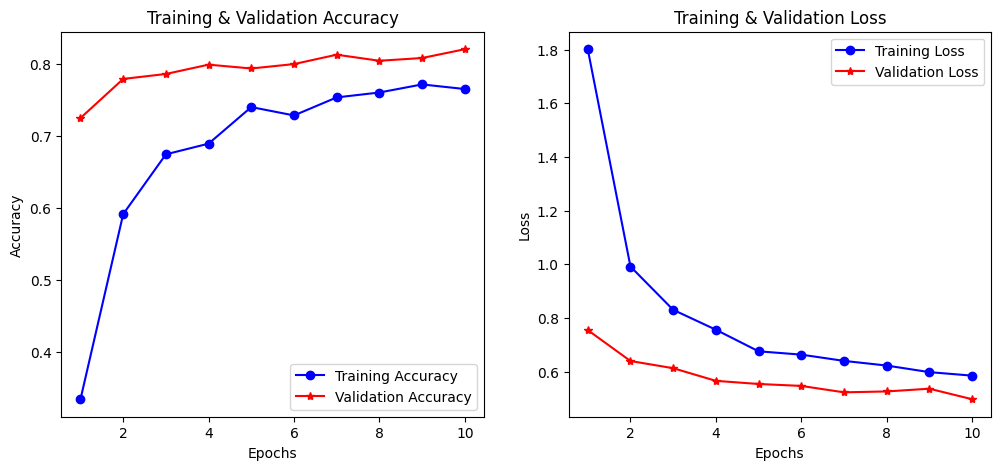

In [1]:
# Re-import required libraries since execution state was reset
import matplotlib.pyplot as plt

# Training history data
epochs = range(1, 11)
accuracy = [0.3348, 0.5914, 0.6743, 0.6891, 0.7398, 0.7282, 0.7532, 0.7600, 0.7712, 0.7648]
val_accuracy = [0.7246, 0.7788, 0.7857, 0.7986, 0.7933, 0.7994, 0.8124, 0.8040, 0.8078, 0.8200]
loss = [1.8016, 0.9916, 0.8303, 0.7561, 0.6757, 0.6633, 0.6400, 0.6226, 0.5981, 0.5850]
val_loss = [0.7548, 0.6395, 0.6127, 0.5656, 0.5539, 0.5467, 0.5228, 0.5261, 0.5363, 0.4971]

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Save trained model
model.save('/content/drive/MyDrive/DL_Project/models/densenet_brain_tumor.h5')